# Health Study Python INL1 - Martin Westberg

In [1]:
# För att få relative path utifrån notebookens workspace mapp.
import sys, os 
sys.path.append(os.path.abspath(".."))

In [2]:
# Läs in datan och visa upp sista 2 raderna (data health check)
import pandas as pd
df = pd.read_csv("./data/health_study_dataset.csv")
df.tail(2)

,id,age,sex,height,weight,systolic_bp,cholesterol,smoker,disease
798,799,50,F,172.6,55.3,155.0,3.58,No,0
799,800,50,M,189.2,79.4,139.7,5.62,No,0


In [3]:
df.info() # inga NaN. Length är 800 rader.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           800 non-null    int64  
 1   age          800 non-null    int64  
 2   sex          800 non-null    object 
 3   height       800 non-null    float64
 4   weight       800 non-null    float64
 5   systolic_bp  800 non-null    float64
 6   cholesterol  800 non-null    float64
 7   smoker       800 non-null    object 
 8   disease      800 non-null    int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 56.4+ KB


## 1. Beskrivande analys

Vi ska räkna ut medel, median, min & max för: age, weight, height, systolic_bp, cholestrol.

Det blir lättast visualiserat med en Pandas DataFrame:

In [11]:
import numpy as np
age  = df['age']
weig = df['weight']
heig = df['height']
syst = df['systolic_bp']
chol = df['cholesterol']

summary = pd.DataFrame({
    "Age": [age.mean(), age.median(), age.min(), age.max()],
    "Weight": [weig.mean(), weig.median(), weig.min(), weig.max()],
    "Height": [heig.mean(), heig.median(), heig.min(), heig.max()],
    "Blood Pressure": [syst.mean(), syst.median(), syst.min(), syst.max()],
    "Cholesterol": [chol.mean(), chol.median(), chol.min(), chol.max()]
}, index=["Mean","Median","Max", "Min"])

display(summary.round(1))

,Age,Weight,Height,Blood Pressure,Cholesterol
Mean,49.4,73.4,171.8,149.2,4.9
Median,50.0,73.2,171.4,149.4,5.0
Max,18.0,33.7,144.4,106.8,2.5
Min,90.0,114.4,200.4,185.9,7.9


---

Vi ska skapa 3 olika grafer.

Det blir ett histogram av blodtrycksvärden, för att se hur många som hamnar i inkrementerade intervall.

Det blir även en boxplot som ska visa hur män och kvinnor väger, då medelvärden, medianer, kvadranter och outliers presenteras.

Det blir slutligen en bar graf av hur många som röker, vilket ger en enkel kategorisk jämförelse.

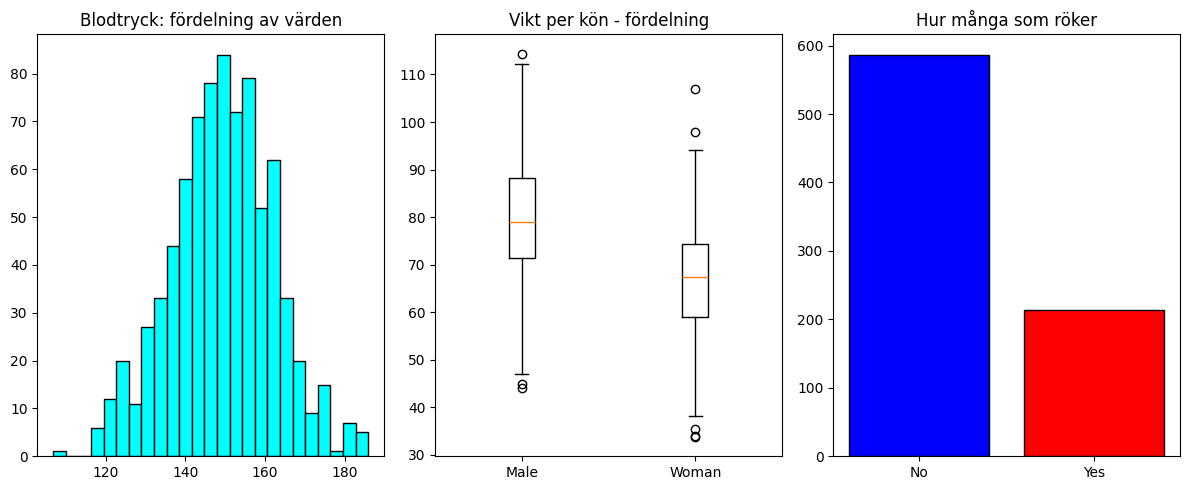

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,3, figsize=(12,5)) # 3 plots i samma figur

# Plot längst till vänster 
# (histogram över blodtryck)
ax[0].hist(df["systolic_bp"], bins=25, edgecolor="black",color="cyan")
ax[0].set_title("Blodtryck: fördelning av värden")

# Plot i mitten 
# (boxplot, vikt per kön)
gender_weights = [df[df['sex']=="M"]['weight'], df[df['sex']=="F"]['weight']] # lista med män's vikt och kvinnor's vikt
ax[1].boxplot(gender_weights, tick_labels=['Male','Woman'])
ax[1].set_title("Vikt per kön - fördelning")

# Plot till höger 
# (stapeldiagram: andelen rökare)
quantity_smokers = df['smoker'].value_counts() # räknar hur många "Yes" och "No" i kolumnen 'smoker'
ax[2].bar(quantity_smokers.index, quantity_smokers.values, edgecolor="black", color=["blue","red"])
ax[2].set_title("Hur många som röker")

plt.tight_layout()
plt.show()

Kommentar:
- Till vänster ser vi ett till synes normalt fördelat histogram, där väldigt få har lägre än 120 och få har högre än 180, och flest har runt 150 i blodtryck.
- I mitten ser vi att män brukar väga mer än kvinnor, och det finns outliers. Orange linjer visar medianerna, som är nära mitten (medelvärdena) av lådorna. Whiskers visar hur långt bort från 25:e och 75:e kvartilen värden kan vara utan att anses outliers.
- Till höger ser vi att ca en proportion av 3:1 avstår från att röka.

## 2. Relaterbar simulering

In [17]:
df.head(1) # en titt på df

,id,age,sex,height,weight,systolic_bp,cholesterol,smoker,disease
0,1,57,F,168.9,65.8,141.8,4.58,No,0


In [18]:
is_sick = len(df[df['disease'] == 1]) # vi får att 47st har sjukdomen.
is_sick

47

In [19]:
is_healthy = len(df) - is_sick
is_healthy # vi får att 753 är friska.

sick_vs_healthy = is_sick / len(df)
sick_vs_healthy * 100 # vi får att 5.875% är sjuka.

5.875

In [26]:
# Simulera med numpy:
np.random.seed(42)
n = 1000

# skapar 1000 nummer (0 eller 1) med sannolikhet 1-0.05875 och 0.05875, respektivt.
sim_pop = np.random.choice([0,1], size=n, p=[1-sick_vs_healthy,sick_vs_healthy]) 
print("Andel sjuka i simulerad befolkning: ",sim_pop.mean()) # vi får 0.056

# jämför simulering med actual:
print(f"Riktiga medelvärdet skiljer sig med: {round(sick_vs_healthy - float((sim_pop.mean())),6)} från simulerade medelvärdet.")
# vi får att den riktiga befolkningen har 0.28% mindre sjuka än den simulerade befolkningen.

Andel sjuka i simulerad befolkning:  0.056
Riktiga medelvärdet skiljer sig med: 0.00275 från simulerade medelvärdet.


## 3. Konfidensintervall

In [ ]:
array_systolic = df['systolic_bp'].to_numpy()
array_systolic 

# Normalapproximation (z-score)
mean = array_systolic.mean() # ger 149.178625
sd = array_systolic.std(ddof=0) # använder inte ddof=1 då vi har hela population.
sd # ger ca 12.79 = standardavvikelse
n = len(array_systolic)
se = sd / np.sqrt(n) # ger ca 0.452 = standardfel (dvs osäkerhet i medelvärdet)
z = 1.96

ci_normal = (mean - z*se, mean + z*se)
np.round(ci_normal, 2) # ger ca (148.29, 150.07), 
# Om vi tar stickprov skulle 95% av intervaller som räknas ut med normalapproximation innehålla det äkta medelvärdet.

array([148.29, 150.06])

In [ ]:
n = len(df) # 800 rader i df
np.random.seed(42) # reproducerbarhet (optional)

# Bootstrap
n_boot = 1000 # 1000 bootstrap resamples
boot_means = [] # lagra medelvärdena här
for i in range(n_boot): # loopa 1000 gånger
    sample = np.random.randint(0,n,n) # väljer 800st rader slumpvist med återläggning
    sample_vals = array_systolic[sample] # tar värden från slumpade rader
    boot_means.append(sample_vals.mean()) # beräkna och lagra medelvärde för varje bootstrap sample

ci_boot = (np.percentile(boot_means, [2.5, 97.5])) # 95% intervall där 2.5% ligger till höger och 2.5% till vänster.
display(ci_boot.round(2))
display(np.mean(boot_means).round(3))

array([148.31, 150.1 ])

np.float64(149.185)

In [37]:
# Jämför Normalapproximation och Bootstrap
print(f"Normalapproximerade CI - Bootstrap CI = ({round(ci_boot[0] - ci_normal[0], 3)}, {round(ci_boot[1] - ci_normal[1], 3)})")
print(f"")

Normalapproximerade CI - Bootstrap CI = (0.017, 0.034)



**Kommentar:**

Normalapproximation går under antagandet att blodtrycksvärdena är normalfördelade, vilket bootstrap inte behöver.

Resultaten för numeriska konfidensintervallen skiljde sig med några hundradelar (0.017, 0.034). Detta tyder på att blodtrycksvärdena i hälsodatan är normalfördelade.

**Källor:**

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bootstrap.html

Wackerly, D., Mendenhall, W., Scheaffer, R. (2014). Mathematical Statistics with Applications, 7th Edition (pp. 406-411; Ch 8.5, Confidence Intervals).

## 4. Hypotesprövning

Vi ska testa om hypotesen "rökare har högre medel-blodtryck än icke-rökare".

* Vi antar enligt seder att nollhypotsen $H_0$ är att det inte är någon skillnad i medelvärdena på de två grupperna rökare och icke-rökare.
* Då är alternativa hypotesen $H_a$ eller $H_1$ att det är skillnad i medelvärdena. (Har lite LateX vana)

Bootstrap förutsätter inte normalt fördelad data, så den metoden är relevant och intressant för att se statistiska resultat.

In [40]:
# Bootstrap är mer robust, medan t-test (Welch) är något enklare.

smokers_bp = df.loc[df["smoker"]=="Yes", "systolic_bp"].to_numpy() # gör array med rökare och deras blodtryck
nonsmokers_bp = df.loc[df["smoker"]=="No", "systolic_bp"].to_numpy() # samma. Vi behöver inte .dropna() för detta dataset.

diff = smokers_bp.mean() - nonsmokers_bp.mean() # tror att rökare har högre snitt, så vi subtraherar icke-rökares genomsnitt från rökares.
print("Rökare har ",round(diff,3), " högre blodtryck än icke-rökare i snitt.") # 0.472 högre blodtryck har rökare i snitt.

Rökare har  0.472  högre blodtryck än icke-rökare i snitt.


In [41]:
# Bootstrap
np.random.seed(42)
n_boot = 1000
boot_diffs = []

n_smokers = len(smokers_bp) # 213
n_nonsmokers = len(nonsmokers_bp) # 587

for i in range(n_boot):
    smokers_sample = np.random.choice(smokers_bp, n_smokers, replace=True)
    nonsmok_sample = np.random.choice(nonsmokers_bp, n_nonsmokers, replace=True)
    boot_diffs.append(smokers_sample.mean() - nonsmok_sample.mean())

ci_boot = np.percentile(boot_diffs, [2.5, 97.5])
display(ci_boot.round(3))
round(np.mean(boot_diffs),3)

# Delade upp df i grupp rökare, icke-rökare
# Gjorde 1000 par av bootstrap stickprov
# Lagrade skillnaden i medel för stickproven

array([-1.479,  2.475])

np.float64(0.474)

Tog percentiler för 95% ci av skillnad i medelvärden, och intervallet (-1.48, 2.475) innehåller 0, så hälsodata visar inte statistiskt signifikant skillnad mellan gruppernas blodtryck.

Medelvärdet på bootstrap genomsnitts skillnaderna är dock väldigt nära df's uträknade motsvarande värde.

Vi fortsätter med Welch t-test, som förutsätter ungefärlig normalfördelning men tillåter olika varianser:

In [43]:
# t-test (Welch)
from scipy import stats
t_stat, p_val = stats.ttest_ind(smokers_bp, nonsmokers_bp, equal_var=False)
round(float(t_stat),3), round(float(p_val),3)

# t värdet på ca 0.45 säger hur medelvärdena skiljer sig.
# p värdet är högre än 0.05 så vi kan inte säga att skillnaden (t) är statistiskt signifikant.

(0.45, 0.653)

Medan vi fick ett CI av bootstrap, fick vi t-värde = 0.45 och p = 0.653.

Värdet på t och tidigare observerad skillnad i medelvärden är rätt lika numeriskt, men olika i matematisk metodik.

P-värdet är långt högre än 0.05, så skillnader kan enkelt komma fram slumpmässigt, och vi avfärdar därmed inte nollhypotesen $H_0$.

**Källor:** 

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bootstrap.html

Wackerly, D., Mendenhall, W., Scheaffer, R. (2014). Mathematical Statistics with Applications, 7th Edition. (pp. 406-411; Ch 8.5, Confidence Intervals)

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html

Wackerly, D., Mendenhall, W., Scheaffer, R. (2014). Mathematical Statistics with Applications, 7th Edition. (pp. 537-540; Ch 10.6, Another Way to Report the Results of a Statistical Test: Attained Significance Levels, or p-Values)

Wackerly, D., Mendenhall, W., Scheaffer, R. (2014). Mathematical Statistics with Applications, 7th Edition. (pp. 545-549; Ch 10.8, Small-sample hypothesis testing for $\mu$ and $\mu_1 - \mu_2$)